## Graph and Dataset creation
cf CAIDA database : https://publicdata.caida.org/datasets/as-relationships/serial-2/

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd
import networkx as nx
import pickle
os.popen("export DGLBACKEND=pytorch")
#import dgl as dgl
import time
from sklearn import preprocessing

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

In [2]:
# File to chose among the directory ./data/CAIDA_AS_RELATIONSHIP/

#FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20200101.as-rel2.txt'
FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20210301.as-rel2.txt'

### Various bash functions to check that the graph is correctly created

In [3]:
#---------------------------------------------#
# Function that frame a message in ordrer to  #
#          have a pretty printing             #
#      @param string : message to print       #
#      @return string : the message framed    #
#---------------------------------------------#

def encadre(message):
    print("\n****************************")
    print(message)
    print("****************************\n")
    
#---------------------------------------------#
# Function that display the number of nodes   #
#          of a graph                         #
#      @param file : file to read             #
#      @return int : number of nodes          #
#---------------------------------------------#
    
def nb_nodes_of_file(file):
    return int(os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read())


#---------------------------------------------#
# Function that display the number customer   #
#   provider and peering link of a node       #
#      @param file : file to read             #
#      @return int,int,int : number of        #
#              neighboors of each type        #
#---------------------------------------------#
def nb_peering_customer_provider(ASN):
    nb_peerings =  os.popen("cat %s | grep \"^%s|\||%s|\" | grep -v \".*\-1\" | wc -l" % (FILE_PATH, ASN, ASN)).read()
    nb_customers = os.popen("cat %s | grep \"^%s|.*\-1\" |wc -l " % (FILE_PATH, ASN)).read()
    nb_providers = os.popen("cat %s | grep \"|%s|\-1\" | wc -l" % (FILE_PATH, ASN)).read()
    return nb_peerings.split("\n")[0], nb_customers.split("\n")[0], nb_providers.split("\n")[0]



In [4]:
nb_nodes_file = nb_nodes_of_file(FILE_PATH)
print("Nb nodes of file : " + str(nb_nodes_file))

Nb nodes of file : 71434


In [5]:
nb_type_links = nb_peering_customer_provider(4)
print("Link types and number (p2p, c, p) of node index 4 : " + str(nb_type_links))

Link types and number (p2p, c, p) of node index 4 : ('2', '1', '12')


### Networkx Graph creation 

In [6]:
#AS_dataset_202001 = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20200101.as2types.txt', sep='|')
AS_dataset = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20210301.as2types.txt', sep='|')

# Check of node number
assert (len(AS_dataset.index) == nb_nodes_file)

In [7]:
AS_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71434 entries, 0 to 71433
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ASN           71434 non-null  int64 
 1   source_label  71434 non-null  object
 2   label         71434 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [8]:
print(AS_dataset["label"].value_counts())
print("\n")
print(AS_dataset["source_label"].value_counts())

Transit/Access    54367
Enterprise        13632
Content            3435
Name: label, dtype: int64


CAIDA_class     57895
peerDB_class    12889
manual_class      650
Name: source_label, dtype: int64


In [9]:
#-------------------------------------------------#
#   Function that returns the int representation  #
#          of a label (Content -> 0,              #
#       Transit/Acces->1, Enterprise -> 2)        # 
#      @param srting : label                      #
#      @return networkx graph : int representation#
#                               of label          #
#-------------------------------------------------#


def label_into_int(label):
    
    if (label == 'Content'):
        int_label = 0
    elif (label == 'Transit/Access'):
        int_label = 1
    elif (label == 'Enterprise'):
        int_label = 2
    return int_label

In [10]:
#------------------------------------------------#
# Function that creates a dictionnary with AS    #
#       number as key and its numbering in       #
#       ascending order as value of a graph      #
#      @param file : file to read                #
#      @return dictionnary : dictionnary as      #
#                            describe above      #
#------------------------------------------------#
 
def dictiongraph(file):
    fichier = open(file,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(sorted(list(set(dictio))), l))
    return dictiofinal

- ⚠️ We reverse keys and values in the following function

In [11]:
#------------------------------------------------#
# Same function we just reverse keys and values  #
#------------------------------------------------#

def dictiongraph_inverse(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(l, sorted(list(set(dictio)))))
    return dictiofinal
Dictio_noeud_as = dictiongraph_inverse(FILE_PATH)

In [12]:
#------------------------------------------------#
# Function that creates a Networksx undirected   #
#  graph with AS number as node feature and      #
# ASnumber1|typeoflink|ASnumber2 as edge feature #
#      @param file : file to read                #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#
def creation_graph(file): 
    G = nx.Graph()
    fichier = open(file,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(file)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= str(asn1) + '|p2p|' +str(asn2))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=str(asn1) + '|p2c|' +str(asn2))
        except ValueError:
            pass
    return G

In [13]:
G = creation_graph(FILE_PATH)

In [14]:
#------------------------------------------------#
#   Function that creates a Networksx directed   #
#  graph with AS number as node feature and      #
# ordinal value (2/3 if p2p and 3/3 if p2c)      #
#               as edge feature.                 # 
#      @param file : file to read                #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#
def creation_graph_dirige(file):
   
    G = nx.DiGraph()
    fichier = open(file,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(file)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                
        except ValueError:
            pass
    return G

In [15]:
G_directed = creation_graph_dirige(FILE_PATH)

-  ⚠️ The difference between the following function ans the previous one is that the direction of p2c links is inversed.

In [16]:
#------------------------------------------------#
#   Function that creates a Networksx directed   #
#  graph with AS number as node feature and      #
# ordinal value (2/3 if p2p and 3/3 if p2c)      #
#               as edge feature.                 # 
#      @param file : file to read                #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#
def creation_graph_dirige_inverse(file):
    G = nx.DiGraph()
    fichier = open(file,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(file)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn2],dictio[asn1],type= 3/3)
                
        except ValueError:
            pass
    return G

In [17]:
G_directed_inverse = creation_graph_dirige_inverse(FILE_PATH)

In [18]:
#------------------------------------------------#
#   Function that creates a Networksx directed   #
#  graph with AS number as node feature and      #
# ordinal value (2/3 if p2p and 3/3 if p2c)      #
#               as edge feature.                 # 
#      @param file : file to read                #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#
def creation_graph_float(file):
    G = nx.DiGraph()
    fichier = open(file,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(file)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        #print("G add node : index " + str(i) + ", asn : " + str(num_as) + ", " + AS_dataset['label'][i] + " => " + str(label_into_int(AS_dataset['label'][i])))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 1/3)
        except ValueError:
            pass
    return G

In [19]:
G_float =creation_graph_float(FILE_PATH)

In [20]:
#------------------------------------------------#
#   Function that creates a Networksx directed   #
#  graph with AS number as node feature and      #
#   array  as edge feature                       #
#      @param file : file to read                #
#      @return networkx graph : Graph as         #
#                            describe above      #
#------------------------------------------------#
def creation_graph_array(file):
    G = nx.DiGraph()
    fichier = open(file,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(file)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= np.array([0,1,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type= np.array([0,1,0]))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=np.array([1,0,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type=np.array([0,0,1]))
        except ValueError:
            pass
    return G

In [21]:
G_array=creation_graph_array(FILE_PATH)

- We check if the graph creation is coherent with the text file 

In [22]:
nb_nodes_graph = G.number_of_nodes()
nb_edges_graph = G.number_of_edges()

print("Graph number of nodes :   "  + str(nb_nodes_graph))
print("Graph number of edges :  " + str(nb_edges_graph))

assert(nb_nodes_graph == int(nb_nodes_of_file(FILE_PATH)))
print("\nASSERT NB NODES OK")

Graph number of nodes :   71434
Graph number of edges :  489716

ASSERT NB NODES OK


### Graph first features (label of ASes, degree...)

##### Distribution of AS labels

<AxesSubplot:>

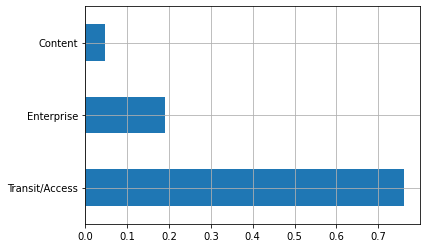

In [23]:
AS_dataset["label"].value_counts(normalize=True).plot(kind='barh', grid=True)

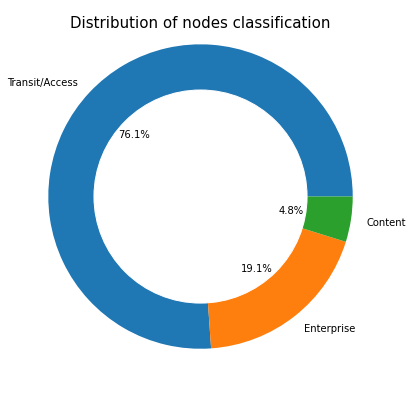

In [24]:
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(AS_dataset['label'].value_counts(), labels=['Transit/Access', 'Enterprise', 'Content'],autopct='%1.1f%%')
fig = plt.gcf()
fig.gca().add_artist(my_circle)
fig.set_size_inches(7,7)
plt.title("Distribution of nodes classification", fontsize=15, x=0.5, y=0.93)
plt.show()

In [25]:
AS_dataset.head(6)

,ASN,source_label,label
0,1,CAIDA_class,Transit/Access
1,2,CAIDA_class,Transit/Access
2,3,CAIDA_class,Transit/Access
3,4,CAIDA_class,Transit/Access
4,5,CAIDA_class,Enterprise
5,6,CAIDA_class,Content


##### Distribution of node degree

In [26]:
def listeNbVoisinsNoeud(G):
    listeDesVoisins = list(G._node)
    nbNoeuds = G.number_of_nodes()
    listenbvoisins = np.zeros(nbNoeuds)
    for i in range(nbNoeuds) :
        listenbvoisins[i] = len(G[listeDesVoisins[i]])
    return listenbvoisins

In [27]:
def listeNvoisins(n,G):
    listeDesVoisins = listeNbVoisinsNoeud(G)
    nbNoeuds = G.number_of_nodes()
    if n>nbNoeuds :
        return "PAS ASSEZ DE NOEUDS DANS LE GRAPHE"
    else :
        ListeNdegresmax = np.zeros(n)
        for i in range(n):
            ListeNdegresmax[i] = max(listeDesVoisins)
            listeDesVoisins = np.delete(listeDesVoisins, listeDesVoisins.tolist().index(max(listeDesVoisins)))
        return ListeNdegresmax

lst=sorted(listeNbVoisinsNoeud(G),reverse = True)
lst=listeNbVoisinsNoeud(G)

Text(0.5, 1.0, 'Distribution of graph degree (log scaled)')

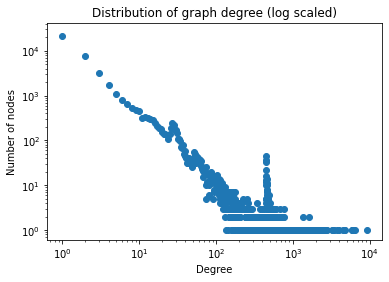

In [28]:
liste_nb_noeud_k_voisin = np.zeros(int(max(lst)))
for i in range(len(lst)) :
    liste_nb_noeud_k_voisin[int(lst[i])-1]+=1

#print(liste_nb_noeud_k_voisin)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("")
 
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.scatter(arange(int(max(lst))),liste_nb_noeud_k_voisin)
plt.title("Distribution of graph degree (log scaled)")

In [29]:
l = np.zeros(4)
for i in range(len(lst)) :
    if lst[i] < 5 :
        l[0]+= 1
    elif lst[i] <100 :
        l[1]+= 1
    elif lst[i] <1000 :
        l[2]+= 1
    else :
        l[3]+= 1

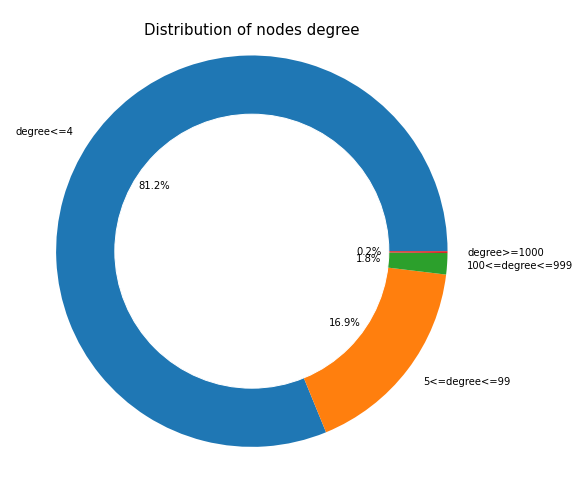

In [30]:
plt.figure(figsize=(9,9))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(l, labels=["degree<=4", "5<=degree<=99", "100<=degree<=999", "degree>=1000"],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Distribution of nodes degree", fontsize=15, x=0.5, y=0.93)
plt.show()

### Computation of some graph features 

##### Adding columns `peering_link`, `customer_link` and `provider_link` 

In [31]:
#-------------------------------------------------------#
#   Function that creates 3 np array to store number    #
#   of peering, customer and provider of each node (AS) #
#      @param file : Networkx Graph                     #
#      @return nparray,nparray,nparray : 3 np array     # 
#                                  as describe above    #
#-------------------------------------------------------#
def nbtypevoisins2(G):
    nbNoeuds = G.number_of_nodes()
    Liste_Nb_Voisins_Peering = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Customer = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Provider = np.zeros(nbNoeuds)
    for i in range(nbNoeuds):
        for j in range(len(G[i])) :
            infos = list(G[i].values())[j]["type"].split("|")
          
            type_lien = infos[1]
            if type_lien == "p2p":

                Liste_Nb_Voisins_Peering[i] +=1
                
            elif type_lien == "p2c":
                asn1 = infos[0]
                asn2 = infos[2]
                if int(asn2) == int(Dictio_noeud_as[i]) :
                     Liste_Nb_Voisins_Provider[i]+=1                
                else :
                    Liste_Nb_Voisins_Customer[i]+=1

        #print(i)

    return Liste_Nb_Voisins_Peering, Liste_Nb_Voisins_Customer, Liste_Nb_Voisins_Provider 
                
#### EXECUTION TIME: 5-10min ~
L1,L2,L3=nbtypevoisins2(G) 

In [33]:
max_degree_list = max(L1 + L2 + L3)
highest_degree_graph = max(list(dict(G.degree()).values()))
index_max = list(dict(G.degree()).values()).index(highest_degree_graph)
ASN_max = list(Dictio_noeud_as.values())[index_max]

print("Max degree list : "  + str(max_degree_list))
print("Max degree index : " + str(index_max) + ", max degree ASN : " + str(ASN_max))
print("Max degree graph : " + str(highest_degree_graph))

assert (max_degree_list == highest_degree_graph)
print("\nASSERT MAX DEGREE OK")

Max degree list : 9083.0
Max degree index : 2475, max degree ASN : 6939
Max degree graph : 9083

ASSERT MAX DEGREE OK


In [49]:
# Extraction of maximum p2p link, customer link and provider link
max_p2p, index_max_p2p = np.max(L1), np.argmax(L1)
max_c,   index_max_c   = np.max(L2), np.argmax(L2)
max_p,   index_max_p   = np.max(L3), np.argmax(L3)

print("Max p2p links          : " + str(max_p2p) + ", index : " + str(index_max_p2p) + ", ASN : " + str(Dictio_noeud_as[index_max_p2p]))
print("Max nb customer links  : " + str(max_c)   + ", index : " + str(index_max_c)   + ", ASN : " + str(Dictio_noeud_as[index_max_c]))
print("Max nb provider links  : " + str(max_p)   + ", index : " + str(index_max_p)   + ", ASN : " + str(Dictio_noeud_as[index_max_p]))

Max p2p links          : 7250.0, index : 2475, ASN : 6939
Max nb customer links  : 6237.0, index : 107, ASN : 174
Max nb provider links  : 137.0, index : 11176, ASN : 20940


In [48]:
AS_dataset.iloc[index_max_p2p]

ASN                       6939
source_label      peerDB_class
label           Transit/Access
Name: 2475, dtype: object

In [36]:
AS_dataset.iloc[index_max_c]

ASN                        174
source_label      peerDB_class
label           Transit/Access
Name: 107, dtype: object

In [37]:
AS_dataset.iloc[index_max_p]

ASN                    20940
source_label    peerDB_class
label                Content
Name: 11176, dtype: object

In [38]:
AS_dataset.head()

,ASN,source_label,label
0,1,CAIDA_class,Transit/Access
1,2,CAIDA_class,Transit/Access
2,3,CAIDA_class,Transit/Access
3,4,CAIDA_class,Transit/Access
4,5,CAIDA_class,Enterprise


##### Vizualisation for ASN 6939

In [39]:
index_max_p2p = AS_dataset.index [AS_dataset['ASN'] == 6939]
print("Nb p2p : "     + str(int(L1[index_max_p2p]))
      + "\nNb c   : " + str(int(L2[index_max_p2p])) 
      + "\nNb p   : " + str(int(L3[index_max_p2p])))

Nb p2p : 7250
Nb c   : 1831
Nb p   : 2


##### Adding columns `page_rank_not_directed`, `page_rank_directed`, `page_rank_directed_inverse` and `degree_centrality`

In [40]:
list_pageRank                  = nx.pagerank(G).values()
list_pageRank_directed         = nx.pagerank(G_directed).values()
list_pageRank_directed_inverse = nx.pagerank(G_directed_inverse).values()
list_degreeCentrality          = nx.degree_centrality(G).values()

In [64]:
# Extraction of maximum page_rank values and ASN (*not_directed*, *directed* and *directed_inverse*)

max_pr_not_dir = np.max(pd.Series(list_pageRank))
max_pr_dir     = np.max(pd.Series(list_pageRank_directed))
max_pr_dir_inv = np.max(pd.Series(list_pageRank_directed_inverse))

indexmax_pr_not_dir = np.argmax(pd.Series(list_pageRank))
indexmax_pr_dir     = np.argmax(pd.Series(list_pageRank_directed))
indexmax_pr_dir_inv = np.argmax(pd.Series(list_pageRank_directed_inverse))

print("Max page_rank value :                 " + str(max_pr_not_dir) + 
      ", ASN related : " + str(Dictio_noeud_as[indexmax_pr_not_dir]) +
      "  (neighbors converging)")

print("Max page_rank_directed value :        " + str(max_pr_dir) + 
      ", ASN related : " + str(Dictio_noeud_as[indexmax_pr_dir]) +
      " (provider converging)")

print("Max page_rank_drected_inverse value : " + str(max_pr_dir_inv) + 
      ", ASN related : " + str(Dictio_noeud_as[indexmax_pr_dir_inv]) +
      " (customer converging)")


Max page_rank value :                 0.010812990990635204, ASN related : 174  (neighbors converging)
Max page_rank_directed value :        0.009920743675492893, ASN related : 6939 (provider converging)
Max page_rank_drected_inverse value : 0.010811150120130737, ASN related : 6939 (customer converging)


In [66]:
#print(indexmax_pr_not_dir)
#print(indexmax_pr_dir)
#print(indexmax_pr_dir_inv)

#print(L1[indexmax_pr_not_dir], L2[indexmax_pr_not_dir], L3[indexmax_pr_not_dir])
#print(L1[indexmax_pr_dir], L2[indexmax_pr_dir], L3[indexmax_pr_dir])
#print(L1[indexmax_pr_dir_inv], L2[indexmax_pr_dir_inv], L3[indexmax_pr_dir_inv])

107
2475
2475
118.0 6237.0 0.0
7250.0 1831.0 2.0
7250.0 1831.0 2.0


In [114]:
AS_dataset['page_rank_not_directed']     = pd.Series(list_pageRank)
AS_dataset['page_rank_directed']         = pd.Series(list_pageRank_directed)
AS_dataset['page_rank_directed_inverse'] = pd.Series(list_pageRank_directed_inverse)
AS_dataset['degree_centrality']          = pd.Series(list_degreeCentrality)

### Addition of other graph-related features

##### Column `degree_normalized` defined by the degre of each node

In [115]:
List_degree = L1 + L2 + L3
AS_dataset['degree_normalized'] = List_degree

In [116]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized
0,1,CAIDA_class,Transit/Access,0.000025,0.000082,0.000017,0.000196,14.0
1,2,CAIDA_class,Transit/Access,0.000034,0.000162,0.000004,0.000294,21.0
2,3,CAIDA_class,Transit/Access,0.000031,0.000067,0.000092,0.000280,20.0
3,4,CAIDA_class,Transit/Access,0.000028,0.000093,0.000004,0.000210,15.0
4,5,CAIDA_class,Enterprise,0.000016,0.000126,0.000004,0.000098,7.0


##### Columns `ratio_peering`, `ratio_customer` and `ratio_provider` defined by the ratio of each node neighbors

In [117]:
AS_dataset['ratio_peering']  = L1
AS_dataset['ratio_customer'] = L2
AS_dataset['ratio_provider'] = L3

In [118]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
0,1,CAIDA_class,Transit/Access,0.000025,0.000082,0.000017,0.000196,14.0,2.0,2.0,10.0
1,2,CAIDA_class,Transit/Access,0.000034,0.000162,0.000004,0.000294,21.0,1.0,2.0,18.0
2,3,CAIDA_class,Transit/Access,0.000031,0.000067,0.000092,0.000280,20.0,5.0,1.0,14.0
3,4,CAIDA_class,Transit/Access,0.000028,0.000093,0.000004,0.000210,15.0,2.0,1.0,12.0
4,5,CAIDA_class,Enterprise,0.000016,0.000126,0.000004,0.000098,7.0,2.0,0.0,5.0


### Exportation of data  : `dataset` and `graph`

We create 4 files : 
- The `dataset` with 8 node-features **that are not already scaled**
- The `graph` nx in pickle format
- The `graph_float` nx in pickle format
- The `graph_array` nx in pickle format

In [119]:
# Exporting data

suffix = FILE_PATH.split('/')[3].split('.')[0]

AS_dataset.to_csv('data_GCN/dataset_v5_'+suffix+'.csv', index=False)
nx.write_gpickle(G, 'data_GCN/graph_'+suffix+'.pickle')
nx.write_gpickle(G_float, 'data_GCN/graph_float_'+suffix+'.pickle')
nx.write_gpickle(G_array, 'data_GCN/graph_array_'+suffix+'.pickle')